# Pasos
- 1 Particionar Train, val, Test
- 2 Particion de las clases de salida(y)
- 3 Preprocesamiento y entrenamiento del modelo cuidadndo el filtrado de informacion (data leakage)
- 4 Ajustar metricas para datos no balanceados 
- 5 Cual es el error es el mas importantes (el que quiero sea mas pequeño)  FN o FP (dalso negativo)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

# Cargar el dataset
data = pd.read_csv('stroke_data.csv')

# Identificar características
numerical_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Crear transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Aplicar transformadores a las columnas correspondientes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Definir características (X) y la variable objetivo (Y)
X = data.drop('stroke', axis=1)
Y = data['stroke']

# Dividir los datos en conjunto de entrenamiento y conjunto temporal (test + val)
X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

# Dividir el conjunto temporal en validación y prueba
X_train, X_val, Y_train, Y_val = train_test_split(X_train_temp, Y_train_temp, test_size=0.25, stratify=Y_train_temp, random_state=42)

# Aplicar el preprocesador a los conjuntos de datos
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

print("Distribución después de SMOTE:")
print(Y_train_resampled.value_counts())

# Crear pipeline completo con preprocesador y modelo
model_smote = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))])

# Entrenar el modelo
model_smote.fit(X_train_resampled, Y_train_resampled)

# Evaluar en el conjunto de validación
Y_pred_val_smote = model_smote.predict(X_val)
print("Informe de clasificación con SMOTE:")
print(classification_report_imbalanced(Y_val, Y_pred_val_smote))

# Evaluar en el conjunto de prueba
Y_pred_test_smote = model_smote.predict(X_test)
print("Informe de clasificación con SMOTE en el conjunto de prueba:")
print(classification_report_imbalanced(Y_test, Y_pred_test_smote))


Distribución después de SMOTE:
stroke
0    2917
1    2917
Name: count, dtype: int64
Informe de clasificación con SMOTE:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.98      0.00      0.97      0.00      0.00       972
          1       0.00      0.00      0.98      0.00      0.00      0.00        50

avg / total       0.90      0.94      0.05      0.92      0.00      0.00      1022

Informe de clasificación con SMOTE en el conjunto de prueba:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.98      0.06      0.96      0.24      0.06       972
          1       0.12      0.06      0.98      0.08      0.24      0.05        50

avg / total       0.91      0.93      0.10      0.92      0.24      0.06      1022



In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced

# Crear el modelo de regresión logística
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# Entrenar el modelo con SMOTE
logistic_model.fit(X_train_resampled, Y_train_resampled)

# Evaluar en el conjunto de validación
Y_pred_val_logistic = logistic_model.predict(X_val)
print("Informe de clasificación con Regresión Logística (Validación):")
print(classification_report_imbalanced(Y_val, Y_pred_val_logistic))

# Calcular balanced accuracy
balanced_accuracy_val_logistic = balanced_accuracy_score(Y_val, Y_pred_val_logistic)
print(f"Balanced Accuracy (Validación): {balanced_accuracy_val_logistic:.2f}")

# Evaluar en el conjunto de prueba
Y_pred_test_logistic = logistic_model.predict(X_test)
print("Informe de clasificación con Regresión Logística (Prueba):")
print(classification_report_imbalanced(Y_test, Y_pred_test_logistic))

# Calcular balanced accuracy
balanced_accuracy_test_logistic = balanced_accuracy_score(Y_test, Y_pred_test_logistic)
print(f"Balanced Accuracy (Prueba): {balanced_accuracy_test_logistic:.2f}")


Informe de clasificación con Regresión Logística (Validación):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.76      0.78      0.86      0.77      0.59       972
          1       0.14      0.78      0.76      0.24      0.77      0.59        50

avg / total       0.94      0.76      0.78      0.83      0.77      0.59      1022

Balanced Accuracy (Validación): 0.77
Informe de clasificación con Regresión Logística (Prueba):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.75      0.78      0.85      0.76      0.58       972
          1       0.14      0.78      0.75      0.23      0.76      0.59        50

avg / total       0.94      0.75      0.78      0.82      0.76      0.58      1022

Balanced Accuracy (Prueba): 0.77


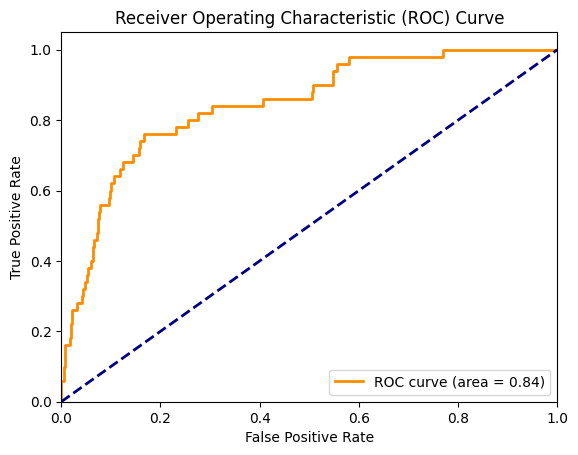

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predecir probabilidades en el conjunto de prueba
Y_prob_test_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob_test_logistic)
roc_auc = roc_auc_score(Y_test, Y_prob_test_logistic)

# Generar la gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [4]:
from imblearn.metrics import geometric_mean_score

# Calcular la métrica G-Mean en el conjunto de validación
gmean_val = geometric_mean_score(Y_val, Y_pred_val_logistic)
print(f"G-Mean (Validación): {gmean_val:.2f}")

# Calcular la métrica G-Mean en el conjunto de prueba
gmean_test = geometric_mean_score(Y_test, Y_pred_test_logistic)
print(f"G-Mean (Prueba): {gmean_test:.2f}")



G-Mean (Validación): 0.77
G-Mean (Prueba): 0.76


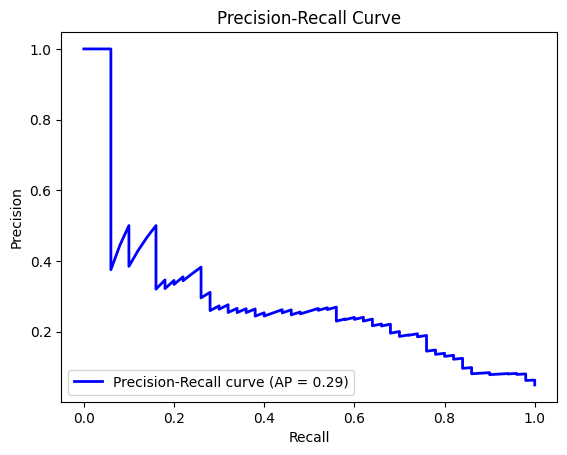

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Predecir probabilidades en el conjunto de prueba
Y_prob_test_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Calcular la curva PR y el AUC
precision, recall, _ = precision_recall_curve(Y_test, Y_prob_test_logistic)
average_precision = average_precision_score(Y_test, Y_prob_test_logistic)

# Generar la gráfica de la curva PR
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


## Paso 1: Entrenar el modelo con SMOTE
- Vamos a entrenar nuevamente el modelo de regresión logística utilizando SMOTE para el sobremuestreo.

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, classification_report_imbalanced
import numpy as np

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Crear el modelo de regresión logística
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# Entrenar el modelo con SMOTE
logistic_model.fit(X_train_resampled, Y_train_resampled)

# Predecir probabilidades en el conjunto de validación
Y_prob_val_logistic = logistic_model.predict_proba(X_val)[:, 1]


ImportError: cannot import name 'classification_report_imbalanced' from 'sklearn.metrics' (C:\Users\arman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\__init__.py)